In [41]:
# from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# drive.mount('/content/drive')

In [42]:
df = pd.read_csv('mdata.csv')
X = df.drop('userid',axis=1)
Y = df['userid']
print(df.head)

<bound method NDFrame.head of        elapsedTime   numEvents   actionType   numCriticalPoints  \
0             4208         114            3                  70   
1             4229         175            3                 109   
2             1674         115            3                  54   
3              510          20            3                   2   
4             6061         305            3                  83   
...            ...         ...          ...                 ...   
93095         1224          40            3                  16   
93096         1688          44            3                  15   
93097         1465          23            3                   9   
93098        13088         245            3                 108   
93099          936          29            3                  14   

       traveledDistance   endToEndLine   largestDeviation   efficiency  \
0                708.37         553.48               0.00         0.78   
1               1



#**Exploratory Data Analysis**

In [43]:
column_mapping = {
    ' numEvents': 'numEvents',
    ' actionType': 'actionType',
    ' numCriticalPoints': 'numCriticalPoints',
    ' endToEndLine': 'endToEndLine',
    ' largestDeviation': 'largestDeviation',
    ' efficiency': 'efficiency',
    ' a_beg_time': 'a_beg_time',
    ' sum_of_angles': 'sum_of_angles',
    ' sdv': 'sdv',
    ' minv': 'minv',
    ' maxv': 'maxv',
    ' sdvx': 'sdvx',
    ' minvx': 'minvx',
    ' maxvx': 'maxvx',
    ' minvy': 'minvy',
    ' maxvy': 'maxvy',
    ' sda': 'sda',
    ' mina': 'mina',
    ' maxa': 'maxa',
    ' sd_omega': 'sd_omega',
    ' min_omega': 'min_omega',
    ' max_omega': 'max_omega',
    ' sd_jerk': 'sd_jerk',
    ' min_jerk': 'min_jerk',
    ' max_jerk': 'max_jerk',
    ' sd_curvature': 'sd_curvature',
    ' min_curvature': 'min_curvature',
    ' max_curvature': 'max_curvature'
}

df.rename(columns=column_mapping, inplace=True)
print(df.columns)

Index(['elapsedTime', 'numEvents', 'actionType', 'numCriticalPoints',
       'traveledDistance', 'endToEndLine', 'largestDeviation', 'efficiency',
       'a_beg_time', 'sum_of_angles', 'avgv', '  sdv', '  minv', 'maxv',
       'avgvx', 'sdvx', 'minvx', 'maxvx', 'avgvy', ' sdvy', 'minvy', 'maxvy',
       'avga', '  sda', '  mina', 'maxa', 'avg_omega', 'sd_omega', 'min_omega',
       'max_omega', 'avg_jerk', 'sd_jerk', 'min_jerk', 'max_jerk',
       'avg_curvature', 'sd_curvature', 'min_curvature', 'max_curvature',
       'direction', 'userid'],
      dtype='object')


# Feature Engineering

In [44]:
def calculate_smooth_index(row):
    if row["sum_of_angles"] == 0.0:
        return 0.0
    else:
        return row["traveledDistance"] / row["sum_of_angles"]

def add_smooth_index_column(df):
    siarr = df.apply(calculate_smooth_index, axis=1)
    df["Smoothindex"] = siarr
    return df

def calculate_fluidity_index(row):
    if row["avg_jerk"] == 0.0:
        return 0.0
    else:
        return row["avgv"] / row["avg_jerk"]

def add_fluidity_index_column(df):
    fluidity_arr = df.apply(calculate_fluidity_index, axis=1)
    df["fluidity"] = fluidity_arr
    return df

def calculate_irregular_index(row):
    return row["largestDeviation"] * row["avg_curvature"]

def add_irregular_index_column(df):
    irregular_index_arr = df.apply(calculate_irregular_index, axis=1)
    df["irregular_index"] = irregular_index_arr
    return df

df = add_smooth_index_column(df)
df = add_fluidity_index_column(df)
df = add_irregular_index_column(df)
print(df.head)
df=df.sample(frac=1)

<bound method NDFrame.head of        elapsedTime  numEvents  actionType  numCriticalPoints  \
0             4208        114           3                 70   
1             4229        175           3                109   
2             1674        115           3                 54   
3              510         20           3                  2   
4             6061        305           3                 83   
...            ...        ...         ...                ...   
93095         1224         40           3                 16   
93096         1688         44           3                 15   
93097         1465         23           3                  9   
93098        13088        245           3                108   
93099          936         29           3                 14   

       traveledDistance  endToEndLine  largestDeviation  efficiency  \
0                708.37        553.48              0.00        0.78   
1               1291.13        385.25              1.90    

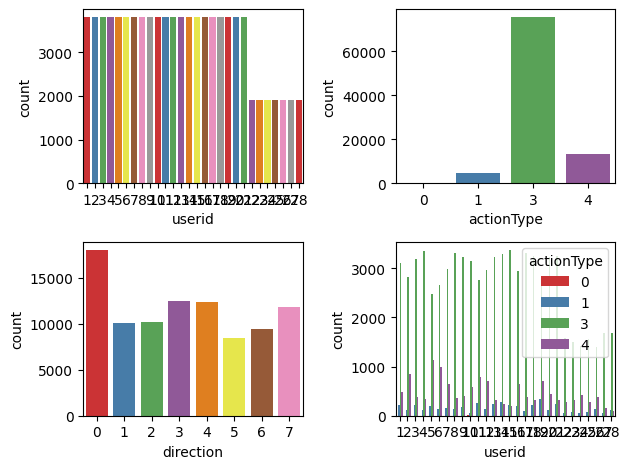

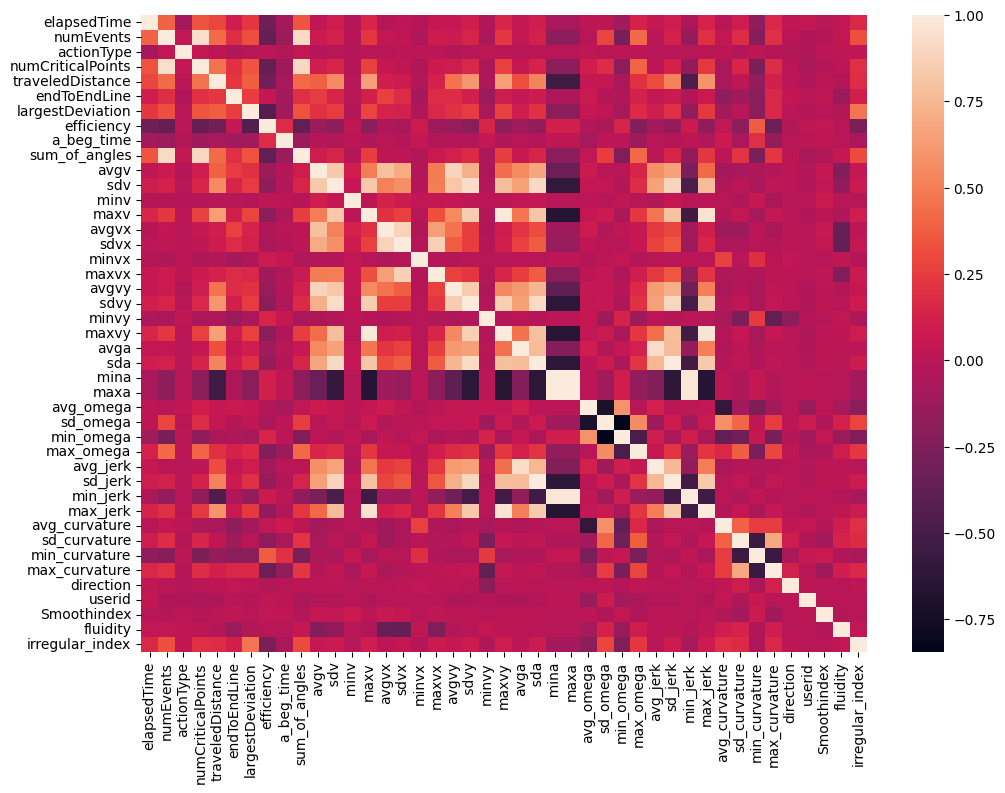

In [45]:
plt.subplot(2, 2, 1)
sns.countplot(x='userid', data=df, palette='Set1')
plt.subplot(2, 2, 2)
sns.countplot(x='actionType', data=df, palette='Set1')
plt.subplot(2, 2, 3)
sns.countplot(x='direction', data=df, palette='Set1')
plt.subplot(2, 2, 4)
sns.countplot(x='userid', data=df, hue='actionType', palette='Set1')
plt.tight_layout()
plt.figure(figsize=(11.7, 8.27))
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, annot=False)
plt.show()

# **Feature Importance**

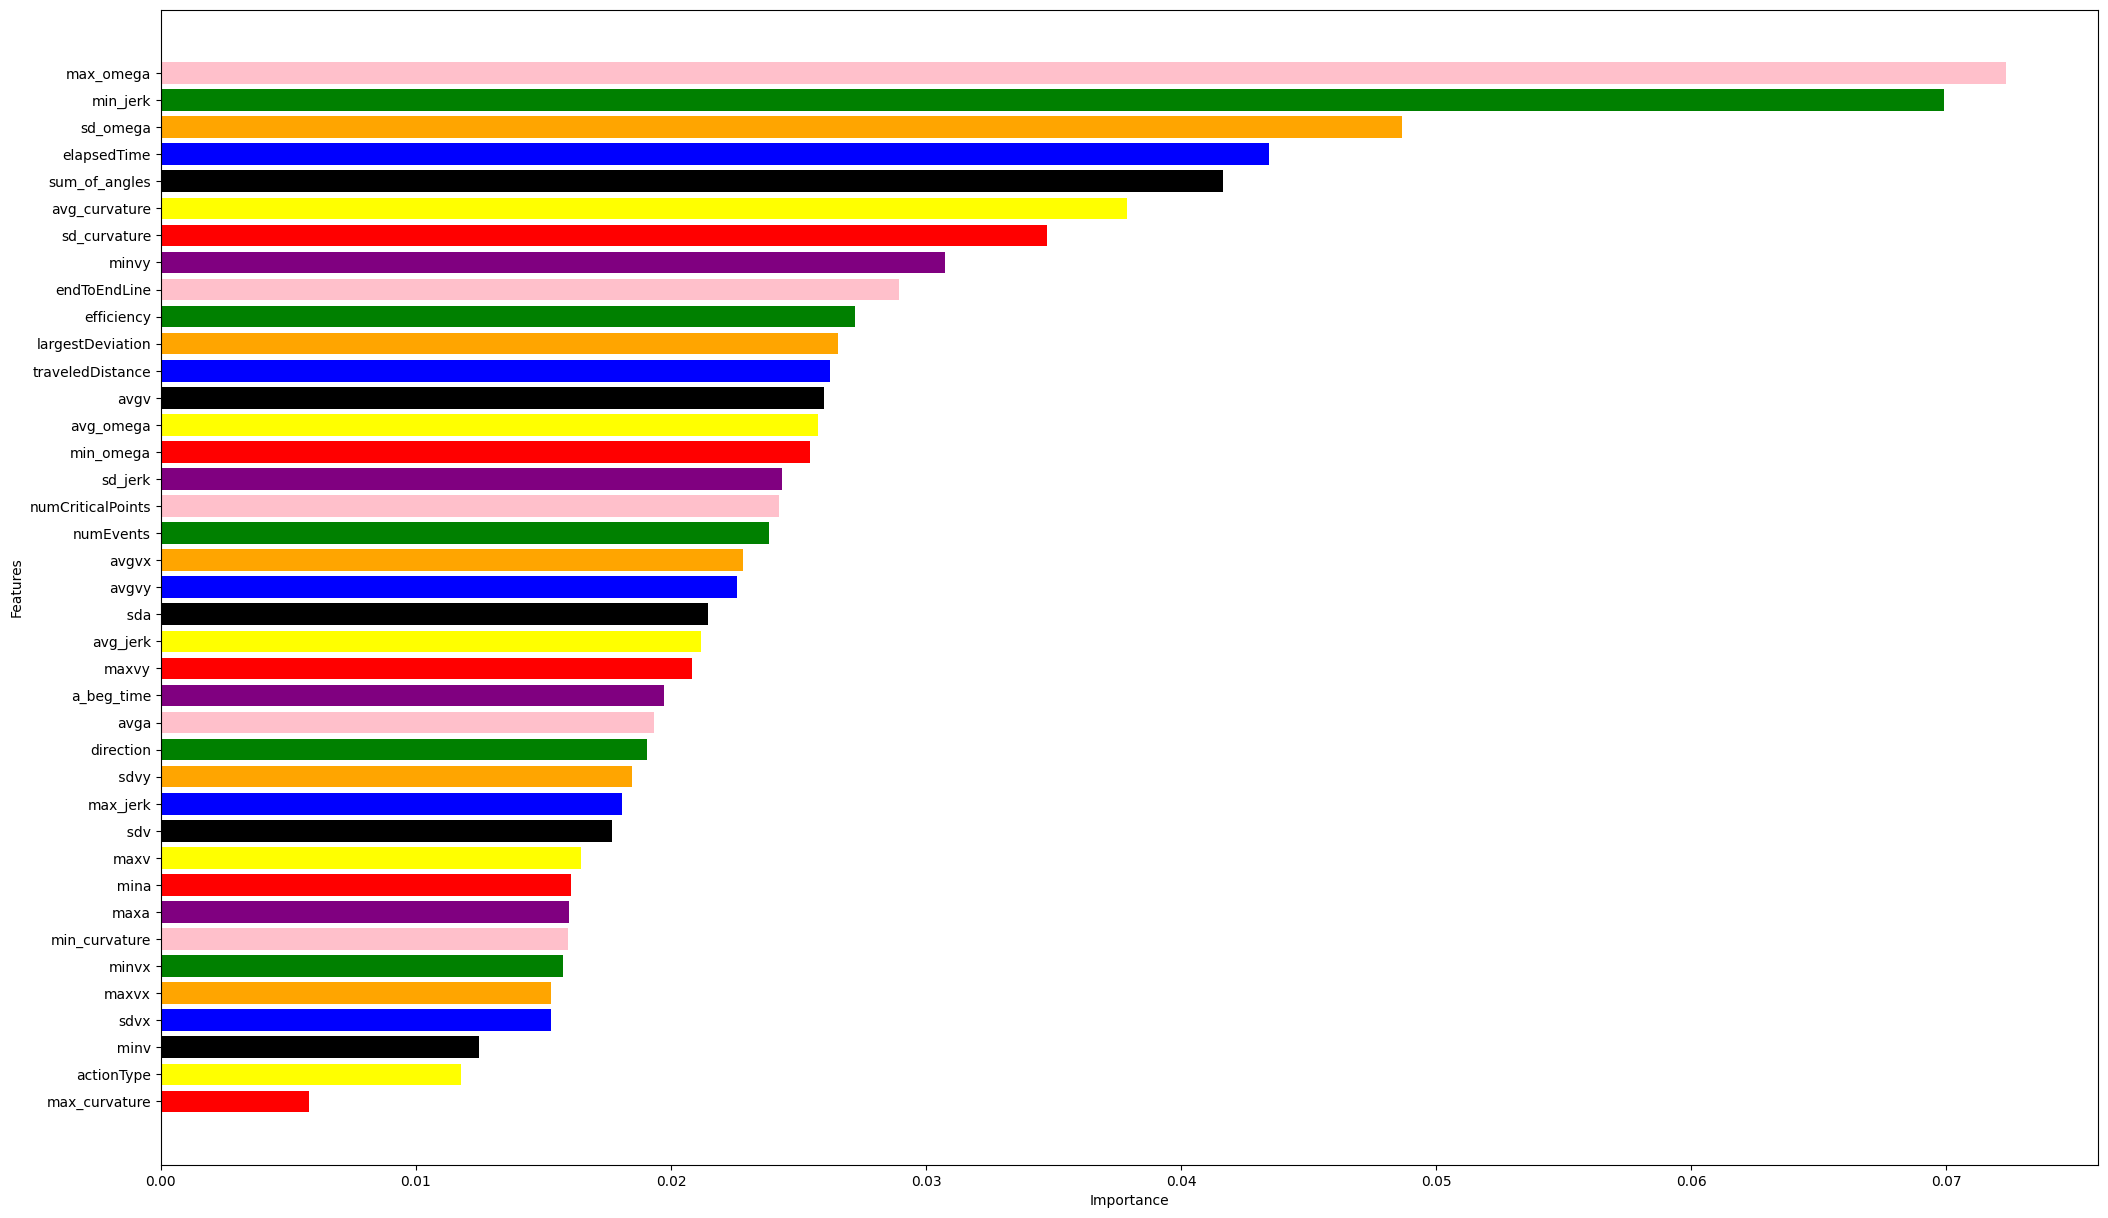

In [54]:
def calculate_feature_importances(model, features):
    importances = model.feature_importances_
    feature_importance_dict = dict(zip(features, importances))
    non_none_features = [feature for feature, importance in feature_importance_dict.items() if importance is not None]
    sorted_features = sorted(non_none_features, key=feature_importance_dict.get)
    sorted_importances = sorted(feature_importance_dict[feature] for feature in sorted_features)
    return sorted_features, sorted_importances

def plot_feature_importance(features, importances, colors=None):
    if colors is None:
        colors = ['red', 'yellow', 'black', 'blue', 'orange', 'green', 'pink', 'purple'] * len(features)

    fig = plt.figure(figsize=(25, 15))
    plt.barh(features, importances, color=colors)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

decision_tree = DecisionTreeClassifier(random_state=42, criterion = 'entropy')
decision_tree.fit(X,Y)
features_list = list(df.drop(['userid'], axis=1))
sorted_features, sorted_importances = calculate_feature_importances(decision_tree, features_list)
plot_feature_importance(sorted_features, sorted_importances)




# TSNE

In [55]:
def visualize_tsne(X, Y, n_components=2, random_state=1, n_iter=1000):
    tsne = TSNE(n_components=n_components, random_state=random_state, n_iter=n_iter)
    tsndata = pd.DataFrame(tsne.fit_transform(X))
    
    scatter = sns.scatterplot(x=tsndata.iloc[:, 0], y=tsndata.iloc[:, 1], hue=Y, palette="tab20", s=50,legend="full")

    plt.title('t-SNE Visualization of Different Classes')
    plt.figure(figsize=(10, 8)) 
    plt.show()

    


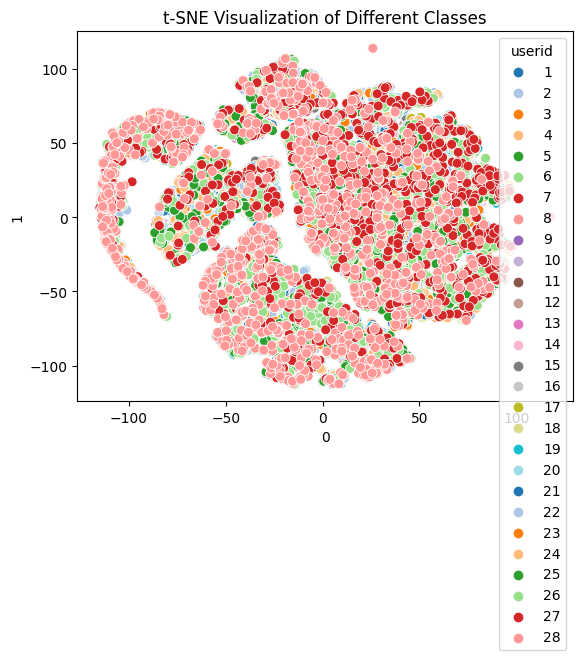

<Figure size 1000x800 with 0 Axes>

In [39]:

df_chao=pd.read_csv('chao.csv')
X_chao = df_chao.drop('userid',axis=1)
Y_chao = df_chao['userid']
visualize_tsne(X_chao, Y_chao, n_components=2, random_state=1, n_iter=1000)

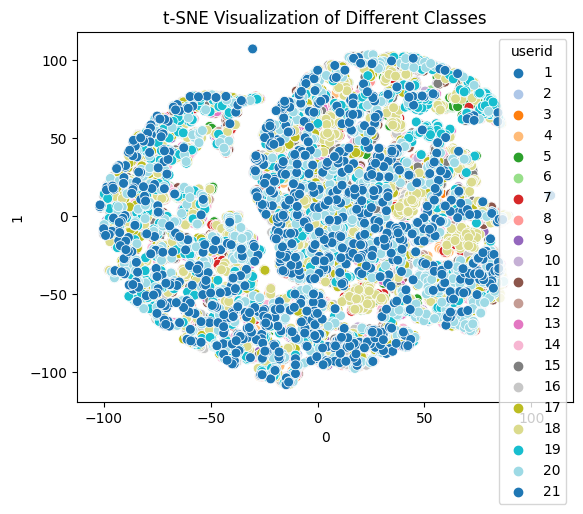

<Figure size 1000x800 with 0 Axes>

In [38]:
df_dfl=pd.read_csv('dfl.csv')
X_dfl= df_dfl.drop('userid',axis=1)
Y_dfl=df_dfl['userid']
visualize_tsne(X_dfl, Y_dfl, n_components=2, random_state=1, n_iter=1000)

#**Models**

In [56]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 100,test_size=0.3,shuffle=True)

In [58]:
X_train

array([[-0.40223762, -0.43043519, -0.07814076, ...,  1.33244286,
         0.552309  , -0.09411728],
       [ 0.06508974,  0.02920506, -0.07814076, ..., -0.83406524,
         0.552309  , -1.35120474],
       [-0.36652399, -0.36741999, -0.07814076, ..., -0.38801945,
         0.552309  ,  0.74394103],
       ...,
       [-0.19303968, -0.21544217, -0.07814076, ...,  0.9341877 ,
        -2.12602773, -1.35120474],
       [-0.2745074 , -0.28587092, -0.07814076, ...,  0.10581695,
         0.552309  , -1.35120474],
       [ 0.39642572, -0.42672841, -0.07814076, ..., -0.34022883,
        -1.46643734,  0.32491187]])

In [59]:
X_test

array([[-0.42282696, -0.37854032, -0.07814076, ..., -0.83406524,
         0.552309  , -0.09411728],
       [-0.35343324, -0.09682533, -3.55147798, ..., -0.83406524,
         0.552309  ,  0.32491187],
       [-0.4098633 , -0.44896907, -0.07814076, ...,  0.9341877 ,
        -2.38586637, -0.09411728],
       ...,
       [-0.29420709, -0.18208119, -0.07814076, ..., -0.83406524,
        -0.36712003, -1.35120474],
       [-0.45854058, -0.41931486, -0.07814076, ...,  1.98558134,
         0.552309  ,  1.16297018],
       [-0.19405643, -0.11535921,  1.65852785, ..., -0.83406524,
         0.552309  , -0.09411728]])

In [60]:
def create_roc_curve(y_true, y_pred, class_label):
    y_true_class = [1 if label == class_label else 0 for label in y_true]
    y_pred_class = [1 if label == class_label else 0 for label in y_pred]

    fpr, tpr, _ = metrics.roc_curve(y_true_class, y_pred_class)
    auc = metrics.roc_auc_score(y_true_class, y_pred_class)

    plt.plot(fpr, tpr, label=f"AUC={auc} for class={class_label}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

def roc_multiclass(y_true, y_pred):
    unique_classes = set(y_true)
    for class_label in unique_classes:
        create_roc_curve(y_true, y_pred, class_label + 1)
    plt.show()


## **Decision Trees**

In [61]:
def train_decision_tree(X_train, y_train, criterion='entropy', splitter='best'):
    clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_pred, y_test)

    print(f"Accuracy: {acc}")
    print(classification_report(y_pred, y_test))

    return y_pred

def print_training_accuracy(clf, X_train, y_train):
    y_pred_train = clf.predict(X_train)
    acc_train = accuracy_score(y_pred_train, y_train)

    print("Accuracy of training data is:")
    print(acc_train)
    print(classification_report(y_pred_train, y_train))

def roc_multiclass(y_true, y_pred):
    unique_classes = set(y_true)
    for class_label in unique_classes:
        create_roc_curve(y_true, y_pred, class_label + 1)
    plt.show()

# Example usage:
# Assuming X_train, y_train, X_test, y_test are your training and testing data
clf = train_decision_tree(X_train, y_train, criterion='entropy', splitter='best')
y_pred = evaluate_classifier(clf, X_test, y_test)
print_training_accuracy(clf, X_train, y_train)


Accuracy: 0.7171142141066953
              precision    recall  f1-score   support

           1       0.69      0.69      0.69      1156
           2       0.80      0.82      0.81      1078
           3       0.71      0.71      0.71      1140
           4       0.78      0.81      0.79      1126
           5       0.77      0.63      0.69      1364
           6       0.68      0.62      0.64      1275
           7       0.73      0.76      0.74      1081
           8       0.75      0.78      0.77      1144
           9       0.69      0.68      0.68      1152
          10       0.71      0.71      0.71      1145
          11       0.70      0.71      0.71      1171
          12       0.70      0.74      0.72      1046
          13       0.68      0.69      0.68      1160
          14       0.69      0.68      0.68      1153
          15       0.65      0.67      0.66      1126
          16       0.77      0.75      0.76      1184
          17       0.76      0.77      0.77      112

## **SVM**

In [25]:
def train_svm(X_train, y_train):
    svm = SVC()
    svm.fit(X_train, y_train)
    return svm

def evaluate_svm(svm, X_test, y_test):
    y_pred = svm.predict(X_test)
    print(classification_report(y_pred, y_test))
    acc = accuracy_score(y_pred, y_test)
    print(f"Accuracy: {acc}")
    return y_pred

def print_training_accuracy_svm(svm, X_train, y_train):
    y_pred_train = svm.predict(X_train)
    acctrain = accuracy_score(y_pred_train, y_train)
    print("Accuracy of training data is:")
    print(acctrain)
    print(classification_report(y_pred_train, y_train))

svm_model = train_svm(X_train, y_train)
y_pred_svm = evaluate_svm(svm_model, X_test, y_test)
print_training_accuracy_svm(svm_model, X_train, y_train)


              precision    recall  f1-score   support

           1       0.17      0.22      0.19       880
           2       0.46      0.36      0.41      1428
           3       0.17      0.28      0.21       717
           4       0.50      0.59      0.54       987
           5       0.23      0.38      0.29       684
           6       0.20      0.23      0.21      1022
           7       0.35      0.64      0.45       615
           8       0.28      0.18      0.22      1814
           9       0.27      0.12      0.17      2536
          10       0.30      0.18      0.22      1930
          11       0.23      0.24      0.24      1148
          12       0.27      0.23      0.25      1303
          13       0.12      0.22      0.15       617
          14       0.18      0.14      0.16      1509
          15       0.09      0.29      0.13       348
          16       0.10      0.36      0.16       328
          17       0.16      0.26      0.20       710
          18       0.45    

## **Random Forest Classifier**

In [26]:
def train_random_forest(X_train, y_train, random_grid, n_iter=10, cv=3, random_state=42):
    rdf = RandomForestClassifier()
    rdf_random = RandomizedSearchCV(estimator=rdf, param_distributions=random_grid, n_iter=n_iter, cv=cv, verbose=2, random_state=random_state)
    rdf_random.fit(X_train, y_train)
    return rdf_random

def evaluate_random_forest(rdf_random, X_test, y_test):
    y_pred = rdf_random.predict(X_test)
    print(classification_report(y_pred, y_test))
    acc = accuracy_score(y_pred, y_test)
    print(f"Accuracy: {acc}")
    return y_pred

def print_training_accuracy_random_forest(rdf_random, X_train, y_train):
    y_pred_train = rdf_random.predict(X_train)
    acctrain = accuracy_score(y_pred_train, y_train)
    print("Accuracy of training data is:")
    print(acctrain)
    print(classification_report(y_pred_train, y_train))

min_samples_leaf = [2, 4, 5, 8, 10]
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=15)],
    'max_features': ['sqrt'], #'auto' is default
    'max_depth': [int(x) for x in np.linspace(10, 60, num=15)] + [None],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True, False]
}

rdf_random_model = train_random_forest(X_train, y_train, random_grid)
y_pred_random_forest = evaluate_random_forest(rdf_random_model, X_test, y_test)
print_training_accuracy_random_forest(rdf_random_model, X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=4, n_estimators=421; total time=  42.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=4, n_estimators=421; total time=  41.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=4, n_estimators=421; total time=  41.7s
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=10, min_samples_split=12, n_estimators=421; total time= 1.0min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=10, min_samples_split=12, n_estimators=421; total time= 1.0min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=10, min_samples_split=12, n_estimators=421; total time= 1.0min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimator

##PCA

In [27]:
def pca_decision_tree(X_train, y_train, X_test, y_test, n_components):
    print(f"For number of components: {n_components}, the report is given below")

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = DecisionTreeClassifier(criterion='entropy', splitter='best')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)

    acc = accuracy_score(y_pred, y_test)
    print(f"Accuracy: {acc}")
    print(classification_report(y_pred, y_test))

for i in range(2, X.shape[1] - 1, 2):
    pca_decision_tree(X_train, y_train, X_test, y_test, n_components=i)


For number of components: 2, the report is given below
Accuracy: 0.6504475474400286
              precision    recall  f1-score   support

           1       0.65      0.65      0.65      1157
           2       0.67      0.65      0.66      1145
           3       0.64      0.65      0.64      1134
           4       0.66      0.65      0.65      1183
           5       0.66      0.53      0.59      1384
           6       0.65      0.66      0.66      1150
           7       0.64      0.67      0.66      1085
           8       0.67      0.69      0.68      1140
           9       0.65      0.66      0.65      1113
          10       0.65      0.69      0.67      1075
          11       0.67      0.68      0.67      1162
          12       0.64      0.65      0.65      1086
          13       0.63      0.67      0.65      1111
          14       0.65      0.65      0.65      1144
          15       0.64      0.67      0.66      1114
          16       0.66      0.66      0.66      11

## **ADA Boost**




In [28]:
def train_ada_boost(X_train, y_train, estimator, n_estimators):
    ada = AdaBoostClassifier(estimator=estimator, n_estimators=n_estimators)
    ada.fit(X_train, y_train)
    return ada

def evaluate_ada_boost(ada, X_test, y_test):
    y_pred = ada.predict(X_test)
    print(classification_report(y_pred, y_test))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")

estimator = DecisionTreeClassifier(criterion='entropy', splitter='best')
n_estimators = 100
ada_boost_model = train_ada_boost(X_train, y_train, estimator=estimator, n_estimators=n_estimators)
evaluate_ada_boost(ada_boost_model, X_test, y_test)


              precision    recall  f1-score   support

           1       0.70      0.69      0.69      1179
           2       0.79      0.80      0.79      1101
           3       0.71      0.75      0.73      1088
           4       0.78      0.84      0.81      1089
           5       0.77      0.68      0.72      1264
           6       0.70      0.66      0.68      1239
           7       0.72      0.76      0.74      1059
           8       0.75      0.76      0.76      1172
           9       0.69      0.68      0.69      1145
          10       0.70      0.71      0.71      1130
          11       0.70      0.70      0.70      1184
          12       0.69      0.68      0.68      1116
          13       0.66      0.69      0.67      1123
          14       0.70      0.71      0.70      1122
          15       0.66      0.66      0.66      1155
          16       0.75      0.74      0.75      1174
          17       0.75      0.73      0.74      1172
          18       0.77    

In [30]:
evaluate_ada_boost(ada_boost_model, X_train, y_train)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2646
           2       1.00      1.00      1.00      2688
           3       1.00      1.00      1.00      2656
           4       1.00      1.00      1.00      2626
           5       1.00      0.87      0.93      3091
           6       1.00      1.00      1.00      2636
           7       1.00      1.00      1.00      2674
           8       1.00      1.00      1.00      2615
           9       1.00      1.00      1.00      2677
          10       1.00      1.00      1.00      2661
          11       1.00      1.00      1.00      2612
          12       1.00      1.00      1.00      2701
          13       1.00      1.00      1.00      2620
          14       1.00      1.00      1.00      2655
          15       1.00      1.00      1.00      2647
          16       1.00      1.00      1.00      2640
          17       1.00      1.00      1.00      2660
          18       1.00    

## **MLP**

In [29]:
def train_mlp_classifier(X_train, y_train, hidden_layer_sizes=(300, 200, 100), random_state=1, max_iter=300):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=max_iter)
    mlp.fit(X_train, y_train)
    return mlp

def evaluate_mlp_classifier(mlp, X_test, y_test):
    y_pred = mlp.predict(X_test)
    print(classification_report(y_pred, y_test))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")

mlp_model = train_mlp_classifier(X_train, y_train)
evaluate_mlp_classifier(mlp_model, X_test, y_test)

              precision    recall  f1-score   support

           1       0.55      0.66      0.60       951
           2       0.76      0.77      0.77      1102
           3       0.62      0.80      0.70       893
           4       0.77      0.70      0.74      1289
           5       0.60      0.50      0.54      1337
           6       0.60      0.57      0.58      1233
           7       0.67      0.68      0.67      1104
           8       0.70      0.74      0.72      1123
           9       0.65      0.56      0.60      1316
          10       0.59      0.65      0.62      1023
          11       0.56      0.70      0.62       955
          12       0.62      0.58      0.60      1188
          13       0.56      0.60      0.58      1111
          14       0.55      0.66      0.60       957
          15       0.56      0.57      0.56      1119
          16       0.65      0.71      0.68      1066
          17       0.74      0.71      0.73      1178
          18       0.69    

In [31]:
evaluate_mlp_classifier(mlp_model, X_train, y_train)

              precision    recall  f1-score   support

           1       0.78      0.90      0.84      2292
           2       0.88      0.90      0.89      2635
           3       0.80      0.95      0.87      2247
           4       0.92      0.83      0.87      2938
           5       0.81      0.73      0.77      2960
           6       0.85      0.80      0.83      2792
           7       0.86      0.84      0.85      2728
           8       0.90      0.91      0.91      2591
           9       0.86      0.80      0.83      2906
          10       0.84      0.89      0.86      2507
          11       0.78      0.88      0.83      2304
          12       0.85      0.81      0.83      2845
          13       0.83      0.85      0.84      2551
          14       0.79      0.89      0.84      2339
          15       0.80      0.83      0.82      2565
          16       0.83      0.89      0.86      2475
          17       0.90      0.89      0.89      2679
          18       0.88    

# XGBOOST

In [35]:
def train_xgb_classifier(X_train, y_train, n_estimators=100):
    xgb_clf = XGBClassifier(n_estimators=n_estimators)
    xgb_clf.fit(X_train, y_train)
    return xgb_clf

def evaluate_xgb_classifier(xgb_clf, X_test, y_test):
    y_pred_xgb = xgb_clf.predict(X_test)
    y_test_original = label_encoder.inverse_transform(y_test)
    y_pred_original = label_encoder.inverse_transform(y_pred_xgb)
    print(classification_report(y_pred_original, y_test_original))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
xgb_model = train_xgb_classifier(X_train, y_train)
evaluate_xgb_classifier(xgb_model, X_test, y_test)


              precision    recall  f1-score   support

           1       0.67      0.75      0.70       664
           2       0.86      0.82      0.84       806
           3       0.80      0.76      0.78       833
           4       0.86      0.85      0.85       736
           5       0.66      0.69      0.67       725
           6       0.69      0.69      0.69       729
           7       0.79      0.80      0.80       731
           8       0.81      0.81      0.81       731
           9       0.72      0.71      0.71       792
          10       0.75      0.70      0.72       863
          11       0.76      0.70      0.73       823
          12       0.76      0.74      0.75       792
          13       0.66      0.70      0.68       690
          14       0.70      0.73      0.71       746
          15       0.68      0.66      0.67       765
          16       0.82      0.80      0.81       773
          17       0.76      0.78      0.77       774
          18       0.79    

In [36]:
evaluate_xgb_classifier(xgb_model, X_train, y_train)

              precision    recall  f1-score   support

           1       0.90      0.95      0.92      2912
           2       0.97      0.95      0.96      3086
           3       0.96      0.95      0.95      3052
           4       0.97      0.97      0.97      3081
           5       0.90      0.85      0.88      3217
           6       0.89      0.95      0.92      2879
           7       0.96      0.94      0.95      3148
           8       0.95      0.95      0.95      3069
           9       0.93      0.91      0.92      3070
          10       0.93      0.91      0.92      3083
          11       0.95      0.91      0.93      3176
          12       0.95      0.92      0.93      3146
          13       0.90      0.94      0.92      2937
          14       0.90      0.94      0.92      2921
          15       0.91      0.92      0.92      3014
          16       0.96      0.94      0.95      3095
          17       0.94      0.95      0.94      2997
          18       0.95    